In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

In [ ]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1..5

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/ImageSegmentaion

Mounted at /content/drive/
/content/drive/My Drive/ImageSegmentaion


In [ ]:
df = pd.read_csv('data/train.csv')
print(df.shape)

(115488, 3)


In [ ]:
!ls

'=2.0.0'   ImageSegmentention.ipynb   model.pt	        uw-madison-gi-tract-image-segmentation.zip
 data	   kaggle.json		      Untitled0.ipynb


In [ ]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
TRAIN_DIR="data/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
#--------------------------------------------------------------------------
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))

tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

#--------------------------------------------------------------------------
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
#--------------------------------------------------------------------------
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
df.head(5)

,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,data/train/case123/case123_day20/scans/slice_0...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,data/train/case123/case123_day20/scans/slice_0...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,data/train/case123/case123_day20/scans/slice_0...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,data/train/case123/case123_day20/scans/slice_0...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,data/train/case123/case123_day20/scans/slice_0...,266,266


In [ ]:
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True);
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
14522,case67_day16_slice_0011,,,,data/train/case67/case67_day16/scans/slice_001...,67,16,0011,266,266,0
12537,case90_day29_slice_0042,,,,data/train/case90/case90_day29/scans/slice_004...,90,29,0042,266,266,0
22525,case89_day20_slice_0014,,,,data/train/case89/case89_day20/scans/slice_001...,89,20,0014,266,266,0
9287,case122_day24_slice_0136,,,,data/train/case122/case122_day24/scans/slice_0...,122,24,0136,266,266,0
17785,case7_day19_slice_0106,16850 3 16900 6 17114 7 17165 8 17182 3 17376 ...,23329 5 23592 14 23841 1 23855 18 24105 6 2412...,,data/train/case7/case7_day19/scans/slice_0106_...,7,19,0106,266,266,2


In [ ]:
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True);
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
26944,case131_day0_slice_0001,,,,data/train/case131/case131_day0/scans/slice_00...,131,0,0001,360,310,0
22206,case89_day21_slice_0063,,,,data/train/case89/case89_day21/scans/slice_006...,89,21,0063,276,276,0
32636,case54_day35_slice_0045,,,,data/train/case54/case54_day35/scans/slice_004...,54,35,0045,266,266,0
681,case77_day0_slice_0106,18198 13 18459 20 18718 28 18979 34 19239 40 1...,19283 10 19548 14 19813 17 20079 18 20344 20 2...,,data/train/case77/case77_day0/scans/slice_0106...,77,0,0106,266,266,2
23396,case143_day23_slice_0021,,,,data/train/case143/case143_day23/scans/slice_0...,143,23,0021,266,266,0


In [ ]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128))
                    y[i,:,:,k] = masks
        if self.subset == 'train': return X, y
        else: return X

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img


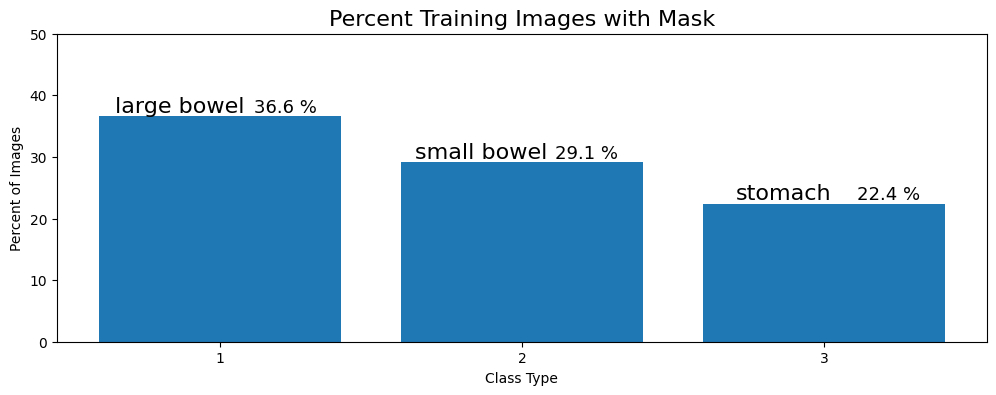

In [ ]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

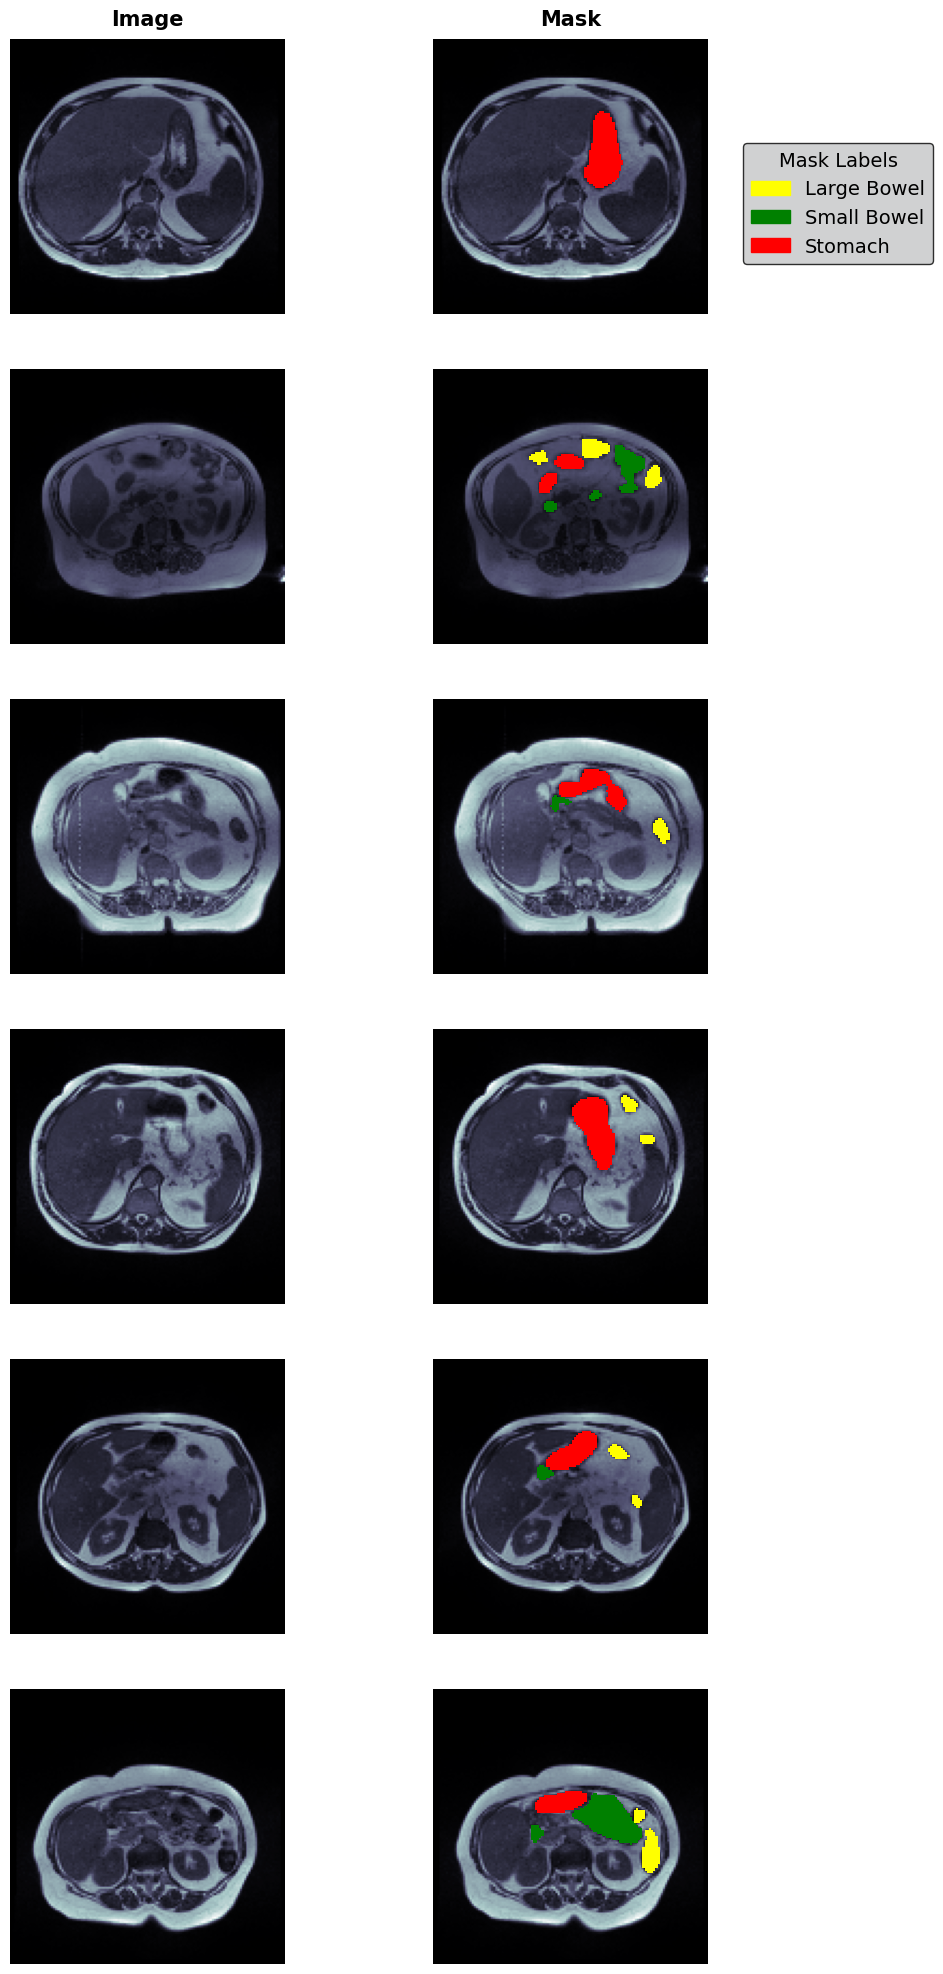

In [ ]:
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]

    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

In [ ]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold

df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [ ]:
display(df_train.groupby(['fold','count'])['id'].count())

fold  count
1     0        4486
      1         485
      2        2230
      3         719
2     0        3847
      1         347
      2        1876
      3         554
3     0        4604
      1         576
      2        2138
      3         634
4     0        4862
      1         734
      2        2400
      3         628
5     0        4107
      1         326
      2        2277
      3         666
Name: id, dtype: int64

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])


In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
! pip install segmentation-models


In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0,

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

258434480/258434480 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 64)           1728      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 64)           256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/10
1992/1992 [==============================] - ETA: 0s - loss: 0.2365 - dice_coef: 0.5739 - iou_coef: 0.3957
Epoch 1: val_loss improved from inf to 0.31974, saving model to model.h5
1992/1992 [==============================] - 1956s 918ms/step - loss: 0.2365 - dice_coef: 0.5739 - iou_coef: 0.3957 - val_loss: 0.3197 - val_dice_coef: 0.4012 - val_iou_coef: 0.5868
Epoch 2/10
1992/1992 [==============================] - ETA: 0s - loss: 0.1321 - dice_coef: 0.7604 - iou_coef: 0.6735
Epoch 2: val_loss did not improve from 0.31974
1992/1992 [==============================] - 736s 369ms/step - loss: 0.1321 - dice_coef: 0.7604 - iou_coef: 0.6735 - val_loss: 0.3208 - val_dice_coef: 0.3949 - val_iou_coef: 0.5076
Epoch 3/10
1992/1992 [==============================] - ETA: 0s - loss: 0.1130 - dice_coef: 0.7953 - iou_coef: 0.7288
Epoch 3: val_loss improved from 0.31974 to 0.29317, saving model to model.h5
1992/1992 [==============================] - 744s 373ms/step - loss: 0.1130 - dice_coe

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

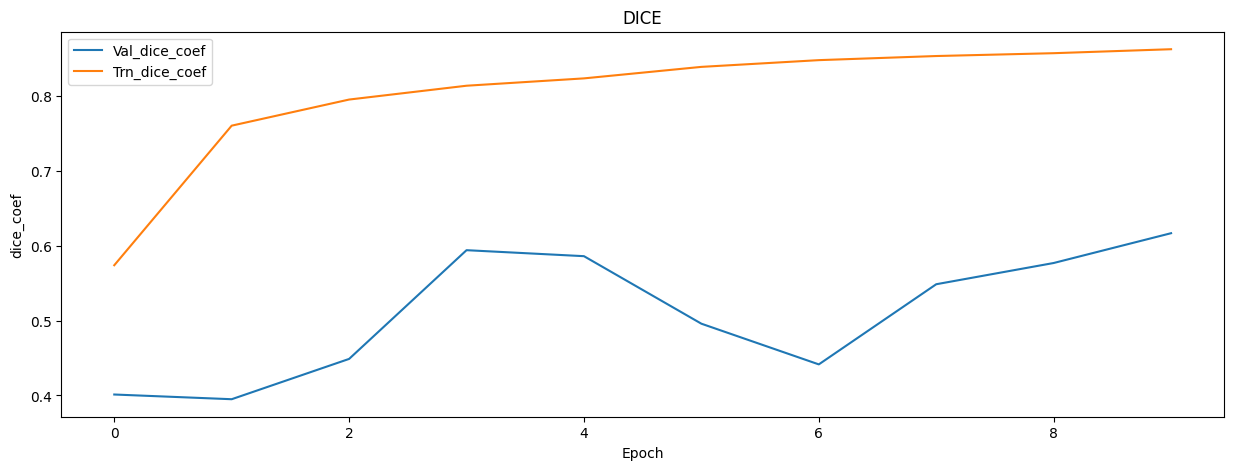

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend();
plt.show()

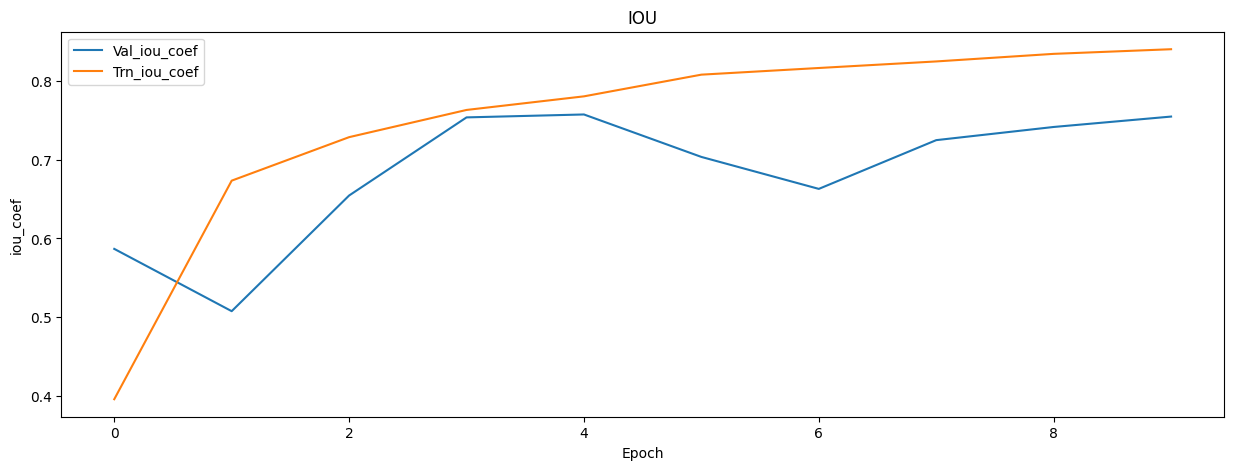

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

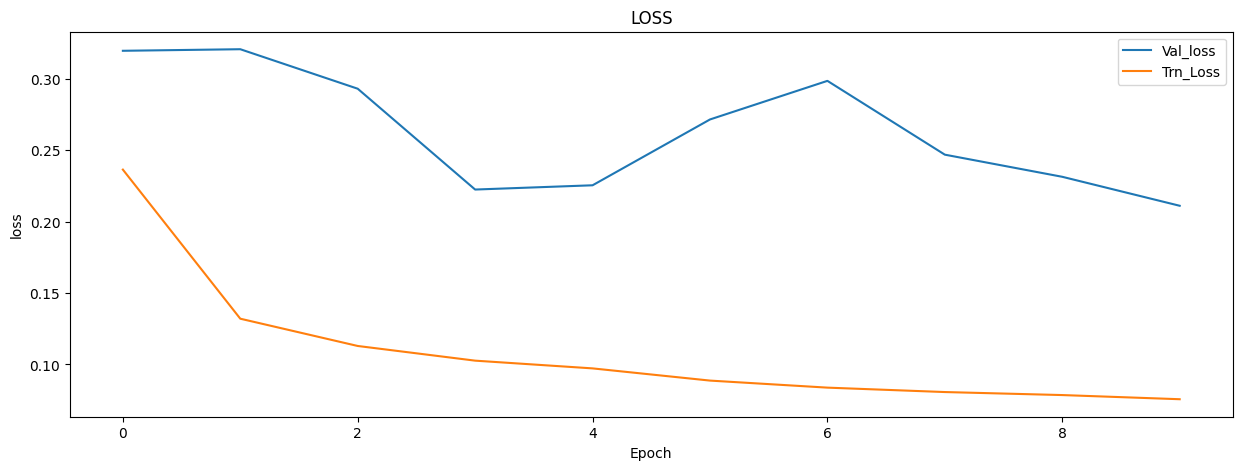

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Trn_Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();
plt.show()

In [ ]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./model.h5', custom_objects=custom_objects)

In [ ]:
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[0:8])],batch_size = 1,shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 6s 30ms/step


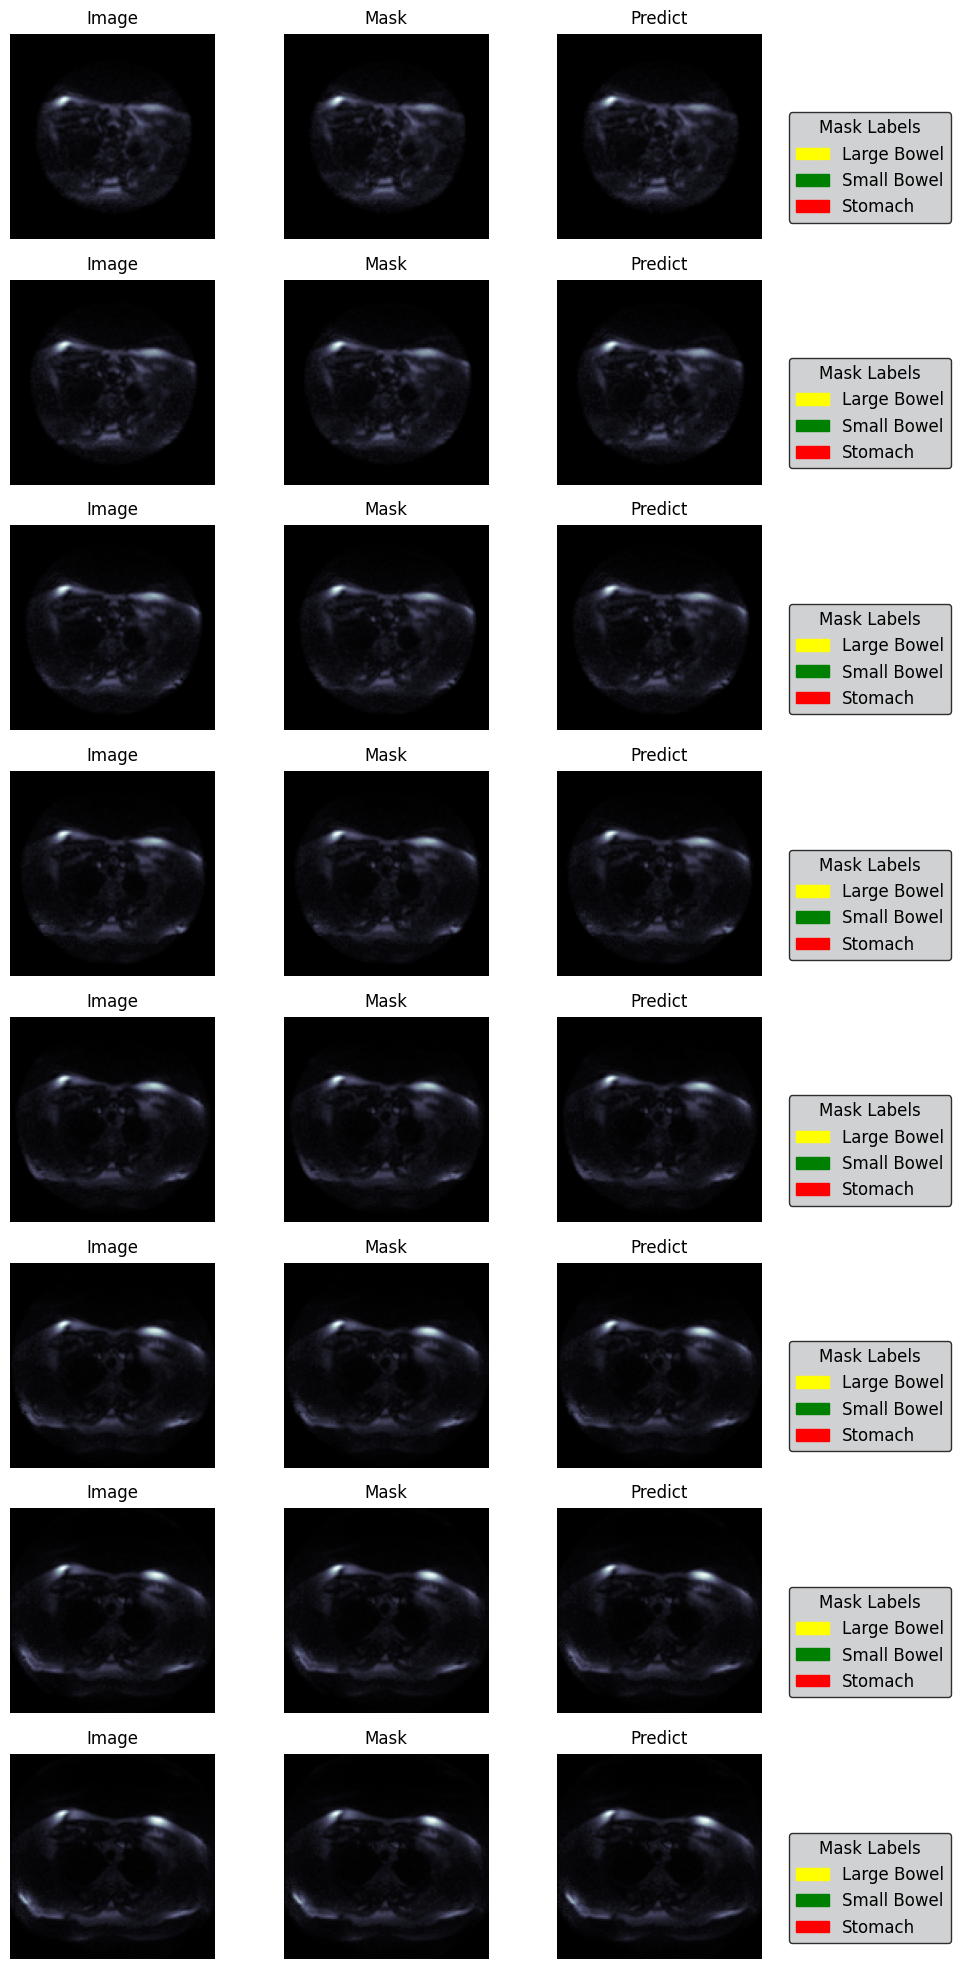

In [ ]:
Threshold = 0.1
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]

    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]

    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)

    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)


    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')